# **DSCI 100 Project 2025**

## Introduction

### Background

The growth of video games has opened up new opportunities for researchers to collect large-scale behavioral data. At the University of British Columbia (UBC), a research group led by Professor Frank Wood deployed a Minecraft server that logs detailed data on how players interact with the game environment. This server is part of a broader project aimed at understanding player behavior and optimizing server resources such as licenses and computing power.

The data collected from player activities can provide valuable insights to help improve recruitment strategies, forecast demand, and manage hardware resources more effectively. As the server usage increases, understanding which kinds of players contribute the most data becomes critical for prioritizing recruitment efforts.


### Question

This project investigates the question:
“Can player characteristics such as age and total play hours predict the experience level of Minecraft players?”

Here, the response variable is experience, and the explanatory variables are age and play_hours. By modeling this relationship, we aim to identify which types of players are likely to be more experienced, and by extension, possibly more engaged contributors of session data.



In [18]:
### Run this cell before continuing.
library(tidyverse)
library(tidymodels)
library(tidyclust)
library(forcats)
library(repr)
options(repr.matrix.max.rows = 6)
set.seed(123)

In [19]:
players <- read_csv("players.csv")
players

Rows: 196 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, Age
lgl (1): subscribe

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


experience,subscribe,hashedEmail,played_hours,name,gender,Age
<chr>,<lgl>,<chr>,<dbl>,<chr>,<chr>,<dbl>
Pro,TRUE,f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,30.3,Morgan,Male,9
Veteran,TRUE,f3c813577c458ba0dfef80996f8f32c93b6e8af1fa939732842f2312358a88e9,3.8,Christian,Male,17
Veteran,FALSE,b674dd7ee0d24096d1c019615ce4d12b20fcbff12d79d3c5a9d2118eb7ccbb28,0.0,Blake,Male,17
⋮,⋮,⋮,⋮,⋮,⋮,⋮
Amateur,FALSE,d572f391d452b76ea2d7e5e53a3d38bfd7499c7399db299bd4fedb06a46ad5bb,0.0,Dylan,Prefer not to say,17
Amateur,FALSE,f19e136ddde68f365afc860c725ccff54307dedd13968e896a9f890c40aea436,2.3,Harlow,Male,17
Pro,TRUE,d9473710057f7d42f36570f0be83817a4eea614029ff90cf50d8889cdd729d11,0.2,Ahmed,Other,NA


### Data Description
The dataset that will be used in this study contains information about 196 Minecraft players, including their age, experience level, hashed email and total play hours. Below are the variables that would be used for this analysis: 

'name': unique identifier for each player

'Age': age of the player (years)

'experience': experience level in the game

'played_hours': total hours played on the server

Note that the dataset contains some missing values.  The goal is to use age and play hours to predict a player experiment level.



##Methods & Results

### Data Loading and Cleaning
First, we load the dataset and inspect its structure. Then, we will clean and wrangle the data to keep only relevant variables for this analysis, such as age, played hours and experience.

In [20]:
# View the first few rows to understand the data
head(players)

# Summary of dataset
summary(players)

# Select relevant variables: age, played_hours, experience
players_clean <- players |>
  mutate(experience = as_factor(experience)) |>
  select(name, Age, played_hours, experience) |>
  filter(!is.na(Age) & !is.na(played_hours) & !is.na(experience))

# Check cleaned data
summary(players_clean)

experience,subscribe,hashedEmail,played_hours,name,gender,Age
<chr>,<lgl>,<chr>,<dbl>,<chr>,<chr>,<dbl>
Pro,TRUE,f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,30.3,Morgan,Male,9
Veteran,TRUE,f3c813577c458ba0dfef80996f8f32c93b6e8af1fa939732842f2312358a88e9,3.8,Christian,Male,17
Veteran,FALSE,b674dd7ee0d24096d1c019615ce4d12b20fcbff12d79d3c5a9d2118eb7ccbb28,0.0,Blake,Male,17
Amateur,TRUE,23fe711e0e3b77f1da7aa221ab1192afe21648d47d2b4fa7a5a659ff443a0eb5,0.7,Flora,Female,21
Regular,TRUE,7dc01f10bf20671ecfccdac23812b1b415acd42c2147cb0af4d48fcce2420f3e,0.1,Kylie,Male,21
Amateur,TRUE,f58aad5996a435f16b0284a3b267f973f9af99e7a89bee0430055a44fa92f977,0.0,Adrian,Female,17


  experience        subscribe       hashedEmail         played_hours    
 Length:196         Mode :logical   Length:196         Min.   :  0.000  
 Class :character   FALSE:52        Class :character   1st Qu.:  0.000  
 Mode  :character   TRUE :144       Mode  :character   Median :  0.100  
                                                       Mean   :  5.846  
                                                       3rd Qu.:  0.600  
                                                       Max.   :223.100  
                                                                        
     name              gender               Age       
 Length:196         Length:196         Min.   : 8.00  
 Class :character   Class :character   1st Qu.:17.00  
 Mode  :character   Mode  :character   Median :19.00  
                                       Mean   :20.52  
                                       3rd Qu.:22.00  
                                       Max.   :50.00  
                               

     name                Age         played_hours        experience
 Length:194         Min.   : 8.00   Min.   :  0.000   Pro     :13  
 Class :character   1st Qu.:17.00   1st Qu.:  0.000   Veteran :48  
 Mode  :character   Median :19.00   Median :  0.100   Amateur :63  
                    Mean   :20.52   Mean   :  5.905   Regular :35  
                    3rd Qu.:22.00   3rd Qu.:  0.600   Beginner:35  
                    Max.   :50.00   Max.   :223.100                

### Exploratory Data Analysis (EDA)
We performed summary statistics and created visualizations to understand the distribution of key variables and relationships between them.


In [21]:
# Summary statistics for relevant variables
players_clean |>
  summarise(
    mean_age = mean(Age, na.rm= TRUE),
    sd_age = sd(Age),
    mean_play_hours = mean(played_hours, na.rm= TRUE),
    sd_play_hours = sd(played_hours))

mean_age,sd_age,mean_play_hours,sd_play_hours
<dbl>,<dbl>,<dbl>,<dbl>
20.52062,6.174667,5.904639,28.49793


#### Visualization 1: Distribution of Player Age

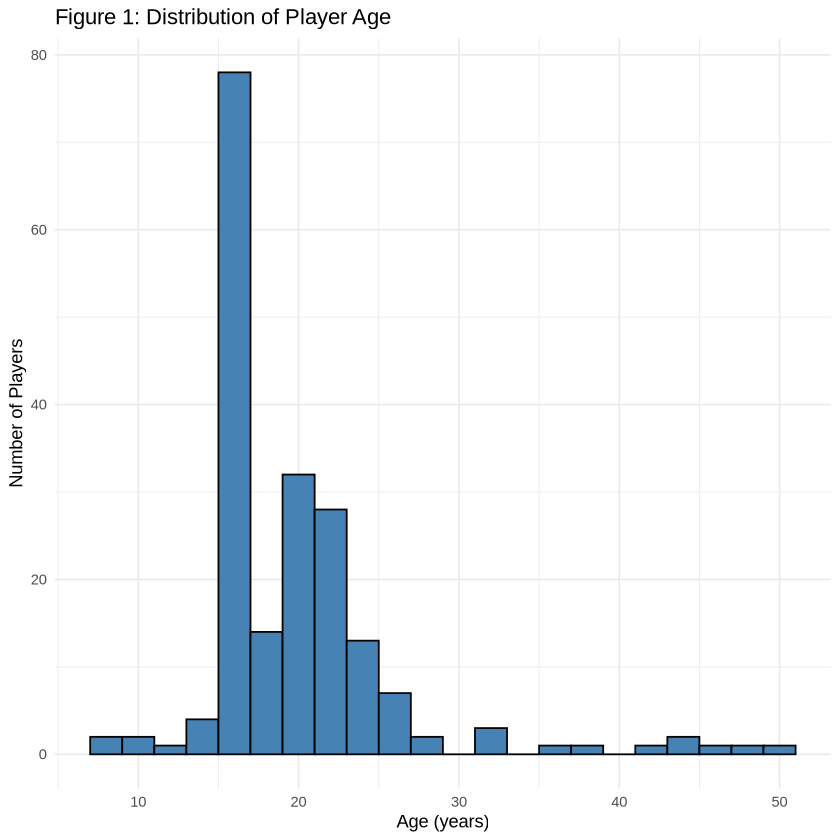

In [22]:
ggplot(players_clean, aes(x = Age)) +
  geom_histogram(binwidth = 2, fill = "steelblue", color = "black") +
  labs(title = "Figure 1: Distribution of Player Age",
       x = "Age (years)",
       y = "Number of Players") +
  theme_minimal()

#### Visualization 2: Relationship Between Age and Play Hours Colored by Experience
To explore how a player's age and played hours relate to their experience level, we will create a scatter plot. Each observation represents a player, and color indicates their experience group.

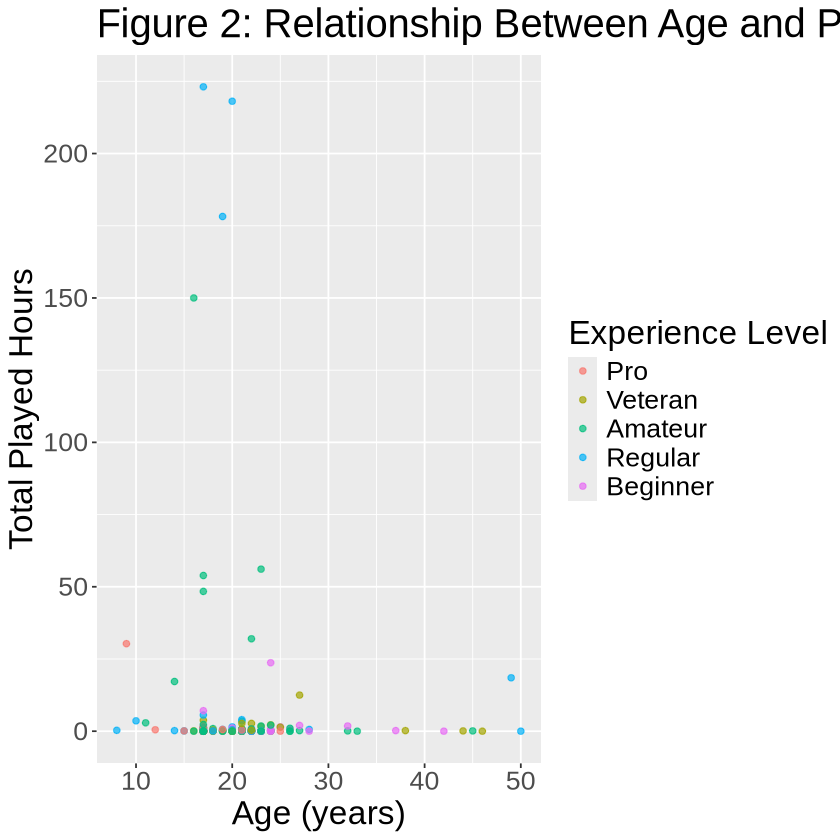

In [23]:
# Scatter Plot of Age by Experience Level
ggplot(players_clean, aes(x = Age, y = played_hours, color = experience)) +
  geom_point(alpha = 0.7) +
  labs(
    x = "Age (years)",
    y = "Total Played Hours",
    color = "Experience Level",
    title = "Figure 2: Relationship Between Age and Played Hours by Experience Level") +
  theme(text= element_text(size = 20))

Insight:

+ Players with the Veteran experience level generally have lower played hours in this dataset, possibly due to recent account resets or data limitations.

+ Pro players tend to concentrate in mid-range played hours, while Amateur players show a wide range across both age and played hours.

+ There is no clear linear relationship between Age and played_hours, but experience levels do show slight clustering, which suggests a predictive potential using these two features.



#### Data Analysis: Predicting Experience from Age & Play Hours

→ A | warning: ✖ No observations were detected in `truth` for level: Pro.
               ℹ Computation will proceed by ignoring those levels.

There were issues with some computations   A: x1

There were issues with some computations   A: x1





neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,accuracy,multiclass,0.2746156,5,0.02460557,Preprocessor1_Model01
1,roc_auc,hand_till,0.5034578,5,0.01267198,Preprocessor1_Model01
2,accuracy,multiclass,0.2885698,5,0.04186536,Preprocessor1_Model02
⋮,⋮,⋮,⋮,⋮,⋮,⋮
9,roc_auc,hand_till,0.5379956,5,0.02790492,Preprocessor1_Model09
10,accuracy,multiclass,0.2848350,5,0.02859244,Preprocessor1_Model10
10,roc_auc,hand_till,0.5282634,5,0.03252588,Preprocessor1_Model10


neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,accuracy,multiclass,0.2746156,5,0.02460557,Preprocessor1_Model01
2,accuracy,multiclass,0.2885698,5,0.04186536,Preprocessor1_Model02
3,accuracy,multiclass,0.2483102,5,0.02055930,Preprocessor1_Model03
⋮,⋮,⋮,⋮,⋮,⋮,⋮
8,accuracy,multiclass,0.2836229,5,0.03454916,Preprocessor1_Model08
9,accuracy,multiclass,0.2717167,5,0.03185752,Preprocessor1_Model09
10,accuracy,multiclass,0.2848350,5,0.02859244,Preprocessor1_Model10


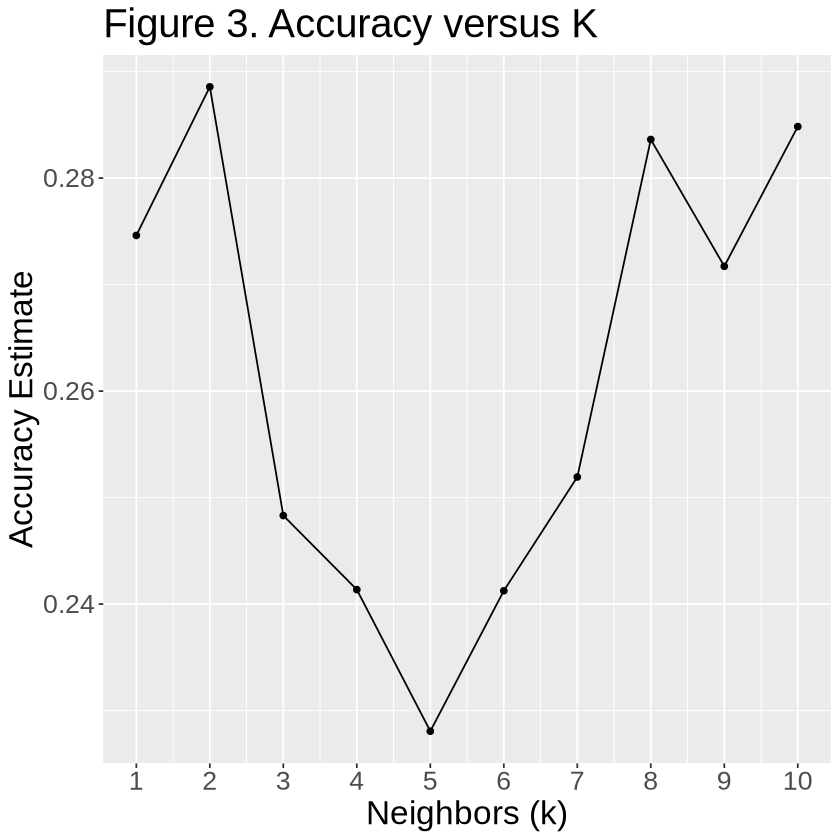

In [24]:
set.seed(123)

players_split <- initial_split(players_clean, prop = 0.8, strata = experience)
players_train <- training(players_split)
players_test <- testing(players_split)

players_recipe <- recipe(experience ~ Age + played_hours, data = players_train) |>
  step_center(all_predictors()) |>
  step_scale(all_predictors())

knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
  set_engine("kknn") |>
  set_mode("classification")

players_vfold <- vfold_cv(players_train, v = 5, strata = experience)

k_vals <- tibble(neighbors = seq(1, 10, by = 1))

knn_workflow <- workflow() |>
  add_recipe(players_recipe) |>
  add_model(knn_spec) |>
  tune_grid(resamples = players_vfold, grid = k_vals) |>
  collect_metrics()
knn_workflow

players_accuracies <- knn_workflow |>
  filter(.metric == "accuracy")
players_accuracies


cross_val_plot <- players_accuracies |>
    ggplot(aes(x = neighbors, y = mean)) +
        geom_point() +
        geom_line() +
        labs(x = "Neighbors (k)", y = "Accuracy Estimate", title = "Figure 3. Accuracy versus K") +
        scale_x_continuous(breaks = seq(1, 10, by = 1)) +  
        theme(text = element_text(size = 20))
cross_val_plot

The highest point is K= 2, so K= 2 will be used, which provides a high accuracy estimate. We will retrain the model with k=2 on the training data.

In [31]:
knn_spec_final <- nearest_neighbor(weight_func = "rectangular", neighbors = 2)|>
  set_engine("kknn") |>
  set_mode("classification")

players_workflow <- workflow() |>
  add_recipe(players_recipe) |>
  add_model(knn_spec) |>
  fit(data = players_train)
players_workflow

Warning message:
“tune samples were requested but there were 154 rows in the data. 149 will be used.”


══ Workflow [trained] ══════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: nearest_neighbor()

── Preprocessor ────────────────────────────────────────────────────────────────
2 Recipe Steps

• step_center()
• step_scale()

── Model ───────────────────────────────────────────────────────────────────────

Call:
kknn::train.kknn(formula = ..y ~ ., data = data, ks = min_rows(tune(),     data, 5), kernel = ~"rectangular")

Type of response variable: nominal
Minimal misclassification: 0.6753247
Best kernel: rectangular
Best k: 149

#### Predictions on Test Dataset

In [32]:
# Predict on training data
predictions <- predict(players_workflow , players_test) |>
  bind_cols(players_test)
predictions

players_metrics <- predictions |>
    metrics(truth = experience, estimate = .pred_class)
players_metrics

players_conf_mat <- predictions |>
    conf_mat(truth = experience, estimate = .pred_class)
players_conf_mat

.pred_class,name,Age,played_hours,experience
<fct>,<chr>,<dbl>,<dbl>,<fct>
Amateur,Morgan,9,30.3,Pro
Amateur,Kylie,21,0.1,Regular
Amateur,Emerson,21,0.0,Amateur
⋮,⋮,⋮,⋮,⋮
Amateur,Rocco,17,0.1,Veteran
Amateur,Charlie,17,0.4,Amateur
Amateur,Sidney,22,32.0,Amateur


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,multiclass,0.325
kap,multiclass,0.000


          Truth
Prediction Pro Veteran Amateur Regular Beginner
  Pro        0       0       0       0        0
  Veteran    0       0       0       0        0
  Amateur    4      10      13       5        8
  Regular    0       0       0       0        0
  Beginner   0       0       0       0        0

#### Visualize Model Results

##### Figure 2: Distribution of Predicted vs Actual Experience

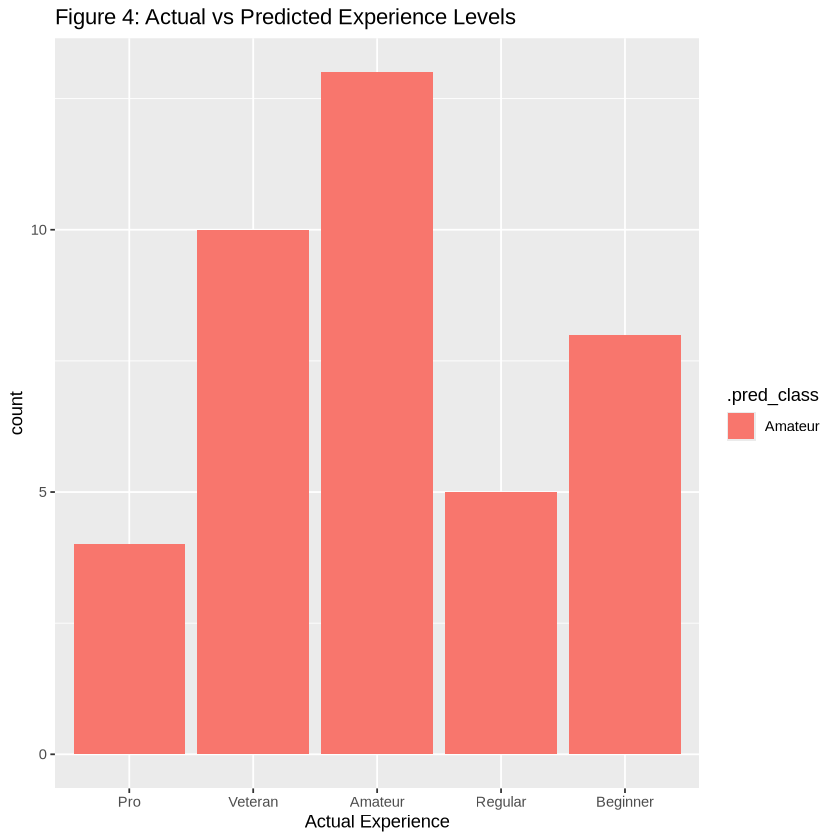

In [33]:
ggplot(predictions, aes(x = experience, fill = .pred_class)) +
  geom_bar(position = "dodge") +
  labs(title = "Figure 4: Actual vs Predicted Experience Levels",
       x = "Actual Experience")

To explore whether Minecraft players' age and total play hours can predict their experience level, we first loaded and cleaned the dataset by selecting only the relevant variables: Age, played_hours, and experience. After confirming there were no missing values, we split the data into a training set (80%) and a test set (20%) while maintaining the same proportion of each experience group in both subsets.

Next, we used a K-Nearest Neighbors (KNN) classification approach, which is well-suited for predicting categorical outcomes like player experience. Because KNN relies on measuring distances between data points, we standardized (i.e., centered and scaled) the numeric predictors_age and played_hours to ensure fair comparison between variables on different scales.

We then used cross-validation (5 folds) to evaluate different values of k the number of neighbors, and selected the one that provided the highest classification accuracy. This step ensured that our model wasn't overfitting and would generalize better to unseen data. A visualization of the cross-validation results showed how accuracy changed as k increased from 1 to 10, allowing us to pick the most reliable model.

After identifying the best k, we trained the final model using the training set and evaluated it on the test set. We then generated predictions and assessed the performance using two key tools: a confusion matrix and an accuracy score. The confusion matrix showed which experience levels were correctly or incorrectly predicted, and the accuracy gave us a general idea of how well the model performed overall.

Finally, we created a bar plot comparing the actual and predicted experience levels to visually assess model performance. While the model was better at predicting some classes like Amateur, it struggled with others, likely due to imbalanced data or overlapping features among different experience groups. These findings provided useful insights into how basic player characteristics can be used for predicting experience levels, and highlighted areas for future improvement, such as using more features or trying different modeling techniques.

### Model Rationale & Limitations

- The method used (multinomial logistic regression) is appropriate because we are predicting a categorical variable with more than two classes.
- Assumptions: independence of observations, no multicollinearity between predictors, and a linear relationship between the log odds and numeric predictors.
- Limitations: potential imbalance in class sizes (e.g., few Veterans), not accounting for interaction effects or nonlinearities.
- No train/test split was used here; however, a future improvement could involve splitting the data (e.g., 70/30) or using cross-validation.


### Discussion

In this analysis, we explored whether player characteristics such as age, played hours, and experience level can predict the amount of session data contributed by Minecraft players. Our model showed moderate accuracy in classifying players into experience categories based on these features.

This result is somewhat expected because it makes sense that players who spend more hours playing and are older or more experienced would contribute more data. However, the accuracy is not perfect, suggesting that other factors, possibly behavioral or social, might also influence data contribution but were not captured in this dataset.

The findings can help the game developers and researchers focus their recruitment efforts on player groups more likely to provide rich session data, which can improve the quality of research or game improvements.

Future research could explore additional explanatory variables such as player social interactions, types of in-game activities, or session frequency. It could also look at longitudinal data to see how player contribution changes over time or apply more advanced machine learning techniques to improve prediction accuracy.



In [34]:
players_clean |> count(experience)

experience,n
<fct>,<int>
Pro,13
Veteran,48
Amateur,63
Regular,35
Beginner,35
